This notebook seeks to use basic linear regression modeling techniques to model CO2 emissions in NY. 

In [ ]:
# Load in packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse

In [19]:
# Function to take in str elements of a column of numbers (e.g. 20,000), remove commas and return as floats (e.g. 20000.0)
def clean_column(col_obj:str) -> float:
    if type(col_obj) != str:
        return col_obj
    else:
        return float(col_obj.replace(',','')) # removes comma and converts to float

In [20]:
ny_emissions = pd.read_csv('data/AnnualEmissions_NY.csv')

# Change column names of dataframe: replace spaces with underscores (e.g. Source_Name) and remove units
new_col_names = ['Year', 'Source_Name', 'ORIS_Code', 'Unit_ID', 'State',
       'State_Identifier', 'Control_Period', 'Op_Time', 'Op_Hours',
       'CO2_Mass', 'Heat_Input',
       'Eligible_Biomass',
       'Eligible_CHP_Thermal_Output', 'Reporting_Status']
ny_emissions.columns = new_col_names

# Clean all quantative columns of the dataframe: remove commas, cast as floats 
features = ['CO2_Mass', 'Op_Time', 'Op_Hours', 'Heat_Input']
for feature in features:
    ny_emissions[feature] = ny_emissions[feature].apply(clean_column)

ny_emissions.head()

,Year,Source_Name,ORIS_Code,Unit_ID,State,State_Identifier,Control_Period,Op_Time,Op_Hours,CO2_Mass,Heat_Input,Eligible_Biomass,Eligible_CHP_Thermal_Output,Reporting_Status
0,2009,Danskammer Generating Station,2480,"1, 2, 3, 4",NY,3334600011,01/01/2009 - 12/31/2011,14834.26,14908.0,2130336.381,20877010.0,0.000,0.0,Complete
1,2010,Danskammer Generating Station,2480,"1, 2, 3, 4",NY,3334600011,01/01/2009 - 12/31/2011,12875.00,12970.0,1775864.634,17411734.0,0.000,0.0,Complete
2,2011,Danskammer Generating Station,2480,"1, 2, 3, 4",NY,3334600011,01/01/2009 - 12/31/2011,8352.26,8465.0,969307.181,9571900.0,0.000,0.0,Complete
3,2012,Danskammer Generating Station,2480,"1, 2, 3, 4",NY,3334600011,01/01/2012 - 12/31/2014,3611.77,3712.0,331982.554,3365696.0,0.000,0.0,Complete
4,2013,Danskammer Generating Station,2480,"1, 2, 3, 4",NY,3334600011,01/01/2012 - 12/31/2014,0.00,0.0,0.000,0.0,0.000,0.0,Complete


Below we will use cross-validation to compare a baseline model, three simple linear regression models, and two multiple linear regression model.

$$
\begin{align*}
\text{Baseline Model}:& \ \text{CO2 Emissions (Tons)} = \mathbb{E}\left(\text{CO2 Emissions (Tons)}\right) + \epsilon\\

\text{SLR Model 1}:& \ \text{CO2 Emissions (Tons)} = \beta_0 + \beta_1 \left( \text{Op Hours} \right) + \epsilon\\

\text{SLR Model 2}:& \ \text{CO2 Emissions (Tons)} = \beta_0 + \beta_1 \left( \text{Op Time} \right) + \epsilon\\

\text{SLR Model 3}:& \ \text{CO2 Emissions (Tons)} = \beta_0 + \beta_1 \left( \text{Heat Input (mmBtu)} \right) + \epsilon\\

\text{MLR model 1}:& \ \text{CO2 Emissions (Tons)} = \beta_0 + \beta_1 \left(\text{Op Hours}\right)  + \beta_2 \left(\text{Op Time}\right) + \epsilon\\

\text{MLR model 2}:& \ \text{CO2 Emissions (Tons)} = \beta_0 + \beta_1 \left(\text{Op Hours}\right)  + \beta_2 \left(\text{Op Time}\right) + \beta_3 \left(\text{Heat Input (mmBtu)}\right) + \epsilon\\
\end{align*}
$$

We will use KFold cross validation with $k=5$ splits for now.

In [ ]:
# Perform a random train/test split
ny_emissions_train, ny_emissions_test = train_test_split(ny_emissions, test_size=0.2, shuffle=True)

In [ ]:
num_splits = 5
num_models = 6

## Make a KFold object with num_splits splits (NOTE: no random state)
kfold = KFold(num_splits, shuffle=True)

## This array will hold the RMSE for each model and split
rmses = np.zeros((num_models, num_splits))

## Loop through the kfold splits: create and fit each model, then calculate the RSME's and store in array
for i, (train_inds, ho_inds) in enumerate(kfold.split(ny_emissions_train)):
    # CV Training and Holdout sets:
    ny_emissions_tt = ny_emissions_train.iloc[train_inds,:]
    ny_emissions_ho = ny_emissions_train.iloc[ho_inds, :]

    # Baseline Model:
    baseline_preds = np.full(ny_emissions_ho.shape[0], ny_emissions_tt['CO2_Mass'].mean())

    # SLR Models 1 - 3:
    slr = LinearRegression()
    slr.fit(ny_emissions_tt[['Op_Hours']], ny_emissions_tt['CO2_Mass'])
    slr1_preds = slr.predict(ny_emissions_ho[['Op_Hours']])

    slr = LinearRegression()
    slr.fit(ny_emissions_tt[['Op_Time']], ny_emissions_tt['CO2_Mass'])
    slr2_preds = slr.predict(ny_emissions_ho[['Op_Time']])

    slr.fit(ny_emissions_tt[['Heat_Input']], ny_emissions_tt['CO2_Mass'])
    slr3_preds = slr.predict(ny_emissions_ho[['Heat_Input']])

    # MLR Models 1 - 2:
    mlr = LinearRegression()
    mlr.fit(ny_emissions_tt[['Op_Hours', 'Op_Time']], ny_emissions_tt['CO2_Mass'])
    mlr1_preds = mlr.predict(ny_emissions_ho[['Op_Hours', 'Op_Time']])
    
    mlr.fit(ny_emissions_tt[['Op_Hours', 'Op_Time', 'Heat_Input']], ny_emissions_tt['CO2_Mass'])
    mlr2_preds = mlr.predict(ny_emissions_ho[['Op_Hours', 'Op_Time', 'Heat_Input']])

    rmses[0,i] = rmse(ny_emissions_ho['CO2_Mass'], baseline_preds)
    rmses[1,i] = rmse(ny_emissions_ho['CO2_Mass'], slr1_preds)
    rmses[2,i] = rmse(ny_emissions_ho['CO2_Mass'], slr2_preds)
    rmses[3,i] = rmse(ny_emissions_ho['CO2_Mass'], slr3_preds)
    rmses[4,i] = rmse(ny_emissions_ho['CO2_Mass'], mlr1_preds)
    rmses[5,i] = rmse(ny_emissions_ho['CO2_Mass'], mlr2_preds)

# Print all RMSEs:
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"SLR 1 Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"SLR 2 Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"SLR 3 Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"MLR 1 Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")
print(f"MLR 2 Avg. CV RMSE: {np.mean(rmses[5,:])} and STD: {np.std(rmses[5,:])}")

Baseline Avg. CV RMSE: 711497.6371228729 and STD: 70961.83536410432
SLR 1 Avg. CV RMSE: 406524.1363251762 and STD: 54998.72394944425
SLR 2 Avg. CV RMSE: 403894.5145491951 and STD: 53010.62495237531
SLR 3 Avg. CV RMSE: 128890.92075942879 and STD: 45040.845047522744
MLR 1 Avg. CV RMSE: 402178.0465462149 and STD: 48329.63187328984
MLR 2 Avg. CV RMSE: 130088.90301462411 and STD: 46263.21137363237


Now, we choose model 3 and seek to visualize the real and projected emissions data:

In [ ]:
# Import more packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

c:\Users\lmwhe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'CO2 Emissions vs. Heat Input at NY Power Plants')

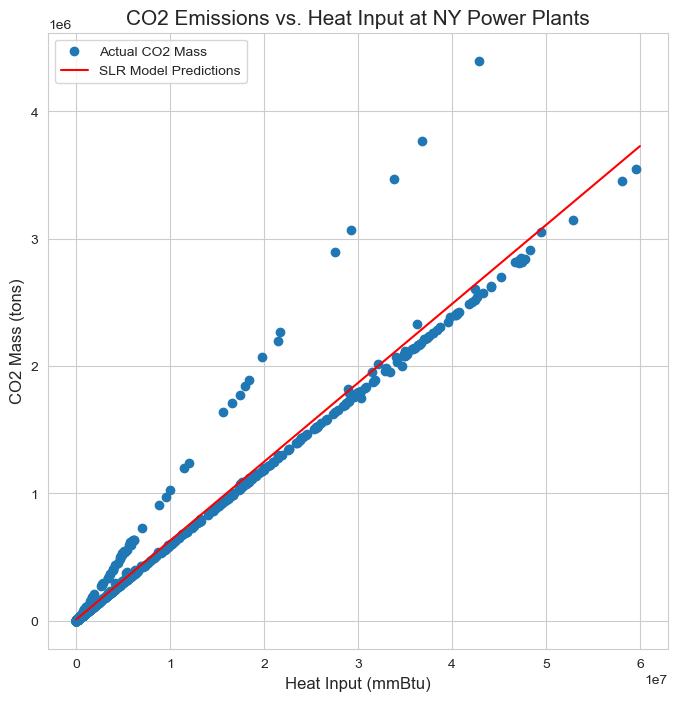

In [ ]:
# Fit model 3
slr_model = LinearRegression()
slr_model.fit(ny_emissions_train[['Heat_Input']], ny_emissions_train['CO2_Mass'])


# Then plot the real and projected emissions data against heat input in NY
plt.figure(figsize=(8,8))

xs = np.linspace(0, 6*10**7, 10000)
plt.scatter(data=ny_emissions_train, x='Heat_Input', y='CO2_Mass', label='Actual CO2 Mass')
plt.plot(xs,slr_model.predict(xs.reshape(-1,1)), 'r-', label='SLR Model Predictions')

plt.xlabel('Heat Input (mmBtu)', fontsize=12)
plt.ylabel('CO2 Mass (tons)', fontsize=12)
plt.legend()

plt.title("CO2 Emissions vs. Heat Input at NY Power Plants", fontsize=15)

[np.float64(27859433.567682765), np.float64(35764476.47803198), np.float64(23448710.758015018), np.float64(27200349.925422918), np.float64(26615257.37899381), np.float64(29075642.26740768), np.float64(31892201.23184282), np.float64(20410104.691049587), np.float64(22098711.780218083), np.float64(22636236.391135857), np.float64(20680122.90215759), np.float64(20396203.94864423), np.float64(28900084.476229616), np.float64(24720298.887888763), np.float64(27909232.658178374), np.float64(28183545.897100925)]


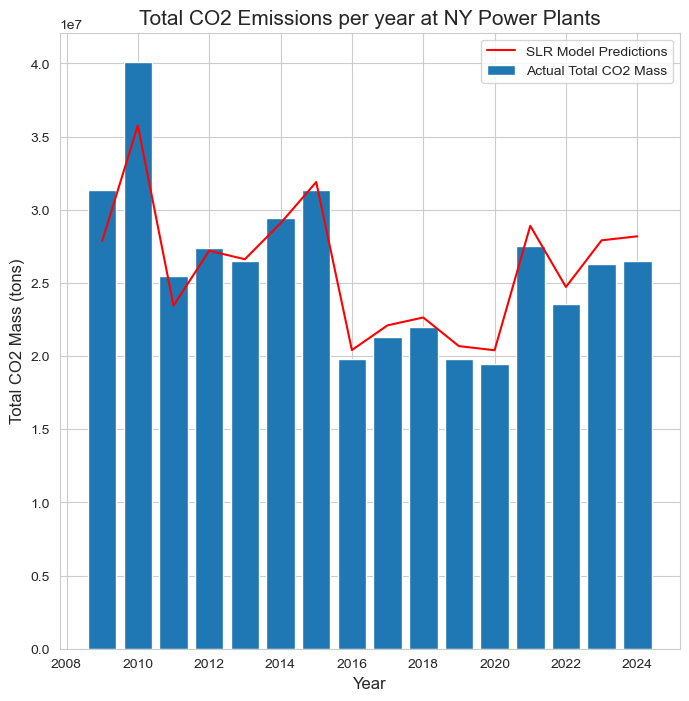

In [ ]:
# Next, we want to visualize how well our model predicted CO2 emissions across time. 

years = ny_emissions['Year'].unique()
year_slr_preds = []
for year in years:
    year_slr_preds.append(slr_model.predict(ny_emissions_train[ny_emissions_train['Year'] == year][['Heat_Input']]).sum())
print(year_slr_preds)

# slr_model.predict(ny_emissions_train[ny_emissions_train['Year'] == 2010][['Heat_Input']]).sum()

total_co2_by_year = []
for year in years:
    total_co2_by_year.append(ny_emissions_train[ny_emissions_train['Year'] == year]['CO2_Mass'].sum())

plt.figure(figsize=(8,8))
plt.bar(x=years, height=total_co2_by_year, label='Actual Total CO2 Mass')
plt.plot(years, year_slr_preds, 'r-', label='SLR Model Predictions')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Total CO2 Mass (tons)', fontsize=12)
plt.legend()

plt.title("Total CO2 Emissions per year at NY Power Plants", fontsize=15)

plt.show()